# Inferring the average size of a rain drop with buckets and SBI
A tutorial for the AI for Science workshop 
by Kyle Cranmer, July, 2025

In [ ]:
import torch

In [2]:
_ = torch.manual_seed(0)

num_dim = 3
def simulator(theta):
    # Linear Gaussian.
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
# number of buckets
n_buckets = 30

# bucket area in m^2
bucket_area = 0.25

# target exposure time in seconds
t_exp = 600

# uncertainty in volume measurement in mL
v_uncert = 12.5

## more complicated model

# uncertainty in time exposure measurement in seconds
t_uncert = 0.1

# relative fluctuation in volume of rain drops (std. dev / mean)
sigma_v_over_v = 0.1

# standard devaition of exposure time in seconds
sigma_t = 1.


In [60]:
def rain_bucket_simple_simulator(flux, mean_v):
    ''' 
     flux in drops / sec / meter^2
     mean_v in mL 
    '''
    n_drops = np.random.poisson(flux * t_exp * bucket_area, size=n_buckets)
    v_true = n_drops*mean_v
    v_obs = np.random.normal(v_true, v_uncert)
    return v_obs

In [61]:
def naive_estimate(v_obs):
    std_v = np.std(v_obs)
    mean_v = np.mean(v_obs)
    # rel_error = 1/sqrt(N)
    # N = 1/rel_error^2
    n_drops_est = (mean_v/std_v)**2
    v_drop_est = mean_v / n_drops_est
    return v_drop_est

In [62]:
def improved_estimate(v_obs):
    std_v = np.std(v_obs)
    mean_v = np.mean(v_obs)
    # uncert^2 = sqrt(N)^2 + v_uncert^2
    # uncert = sqrt(N + v_uncert^2)
    # rel_error = uncert / N*v_drop_est
    # v_drop_est = 
    # N = 1/rel_error^2
    n_drops_est = mean_v**2/(std_v**2-v_uncert**2)
    v_drop_est = mean_v / n_drops_est
    return v_drop_est

In [63]:
v_obs_10_01 = rain_bucket_simple_simulator(flux = 10, mean_v = 0.01)
v_obs_5_1 = rain_bucket_simple_simulator(flux = 1, mean_v = 0.1)

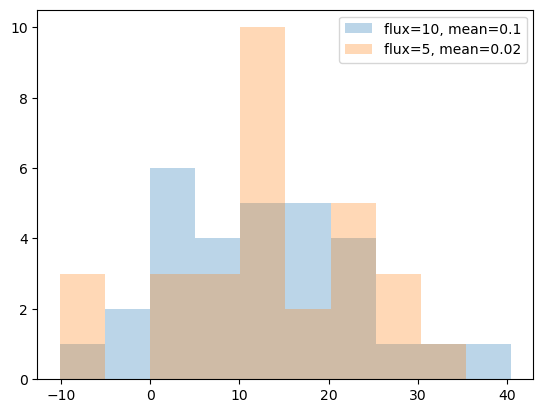

In [64]:
counts, bins, _ = plt.hist(v_obs_10_01, alpha=.3, label='flux=10, mean=0.1')
_ = plt.hist(v_obs_5_1, bins=bins, alpha=.3, label='flux=5, mean=0.02')
plt.legend()

In [65]:
naive_estimate(v_obs_10_01), improved_estimate(v_obs_10_01)

(10.027761159135313, -2.60564534549848)

In [66]:
naive_estimate(v_obs_5_1), improved_estimate(v_obs_5_1)

(7.671774595450618, -4.083057529336665)

In [67]:
temp_flux = 10.
temp_mean_v = 0.01
temp_flux * t_exp * bucket_area * temp_mean_v

15.0

In [68]:
n_train = 1000
# flux range
flux_min, flux_max = 1.,20.
# mean_v range
mean_v_min, mean_v_max = 0.01, .5

# sample from proposal for where to run simulator
flux_samples = np.random.uniform(flux_min, flux_max, size=n_train)
mean_v_samples = np.random.uniform(mean_v_min, mean_v_max, size=n_train)

v_obs_samples = np.zeros((n_train,n_buckets))
naive_estimates = np.zeros(n_train)
improved_estimates = np.zeros(n_train)

for i in range(n_train):
    v_obs_samples[i] = rain_bucket_simple_simulator(flux = flux_samples[i], mean_v = mean_v_samples[i])
    naive_estimates[i] =  naive_estimate(v_obs_samples[i])
    improved_estimates[i] =  improved_estimate(v_obs_samples[i])


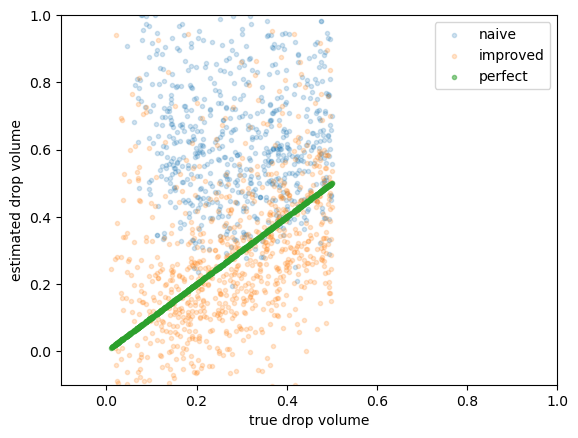

In [69]:
plt.scatter(mean_v_samples,naive_estimates, alpha=.2, marker='.', label='naive')
plt.scatter(mean_v_samples,improved_estimates, alpha=.2, marker='.', label='improved')
plt.scatter(mean_v_samples,mean_v_samples, alpha=.5, marker='.', label='perfect')
plt.xlim(-.1,2*mean_v_max)
plt.ylim(-.1,2*mean_v_max)
plt.xlabel('true drop volume')
plt.ylabel('estimated drop volume')
plt.legend()

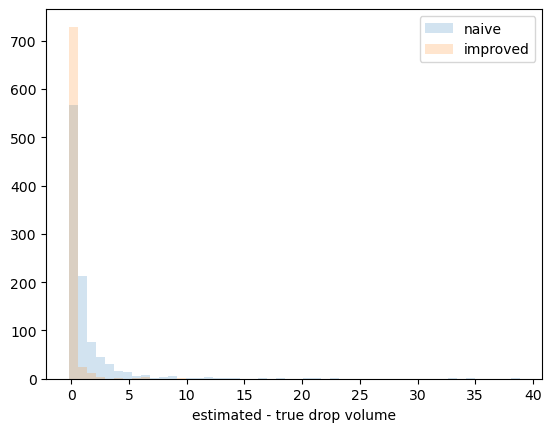

In [70]:
counts, bins, _ = plt.hist(naive_estimates-mean_v_samples, bins=50, alpha=.2, label='naive')
counts, bins, _ = plt.hist(improved_estimates-mean_v_samples, bins=bins, alpha=.2, label='improved')
plt.xlabel('estimated - true drop volume')
plt.legend()

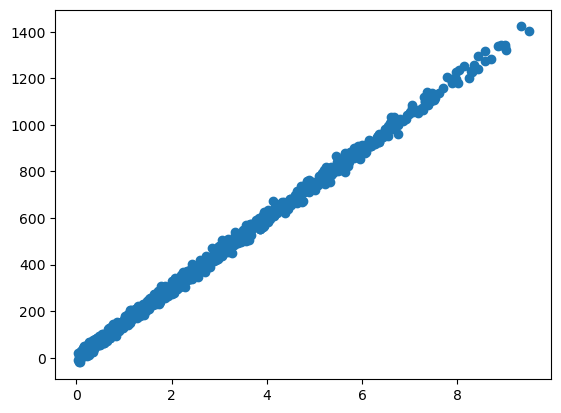

In [71]:
plt.scatter(mean_v_samples*flux_samples, v_obs_samples[:,0])

In [72]:
# save simulated data to file

In [73]:
v_obs_samples.shape

(1000, 30)

In [74]:
mean_summary = torch.tensor(np.mean(v_obs_samples,axis=1),dtype=torch.float)
std_summary = torch.tensor(np.std(v_obs_samples,axis=1),dtype=torch.float)
summaries = torch.vstack((mean_summary, std_summary)).T
summaries

tensor([[351.6670,  14.4074],
        [176.8013,  12.2435],
        [135.1734,  15.1575],
        ...,
        [421.1334,  14.8837],
        [704.8965,  22.4226],
        [310.3567,  17.0899]])

In [75]:
from sbi.utils import BoxUniform

In [76]:
num_params = 2
prior = BoxUniform(low=torch.tensor((flux_min,mean_v_min)), high=torch.tensor((flux_max,mean_v_max)))

In [77]:
from sbi.inference import NPE

inference = NPE(prior=prior)

In [78]:
params_samples = torch.tensor(np.vstack((flux_samples, mean_v_samples)).T,dtype=torch.float)

In [79]:
obs_samples = torch.tensor(v_obs_samples, dtype=torch.float)

In [80]:
#inference = inference.append_simulations(params_samples, obs_samples)
inference = inference.append_simulations(params_samples, summaries)

In [81]:
density_estimator = inference.train()


 Neural network successfully converged after 111 epochs.

In [82]:
posterior = inference.build_posterior()

print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [83]:
x_obs = torch.tensor(rain_bucket_simple_simulator(flux = 10, mean_v = 0.2),dtype=torch.float)
x_obs.shape
summary_obs = torch.as_tensor([torch.mean(x_obs), torch.std(x_obs)], dtype=torch.float)

In [84]:
#samples = posterior.sample((10000,), x=x_obs)
samples = posterior.sample((10000,), x=summary_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

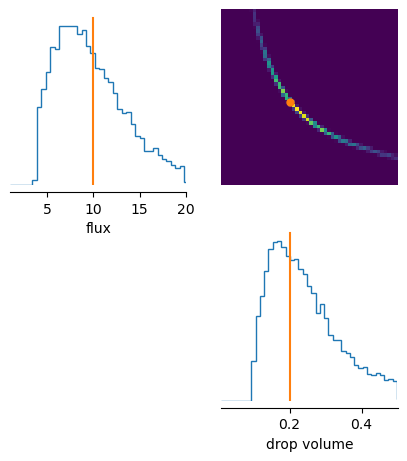

In [85]:
from sbi.analysis import pairplot

_ = pairplot(
    samples,
    points=np.array((10,0.2)),
    limits=[[flux_min, flux_max], [mean_v_min, mean_v_max]],
    figsize=(5, 5),
    labels=[r"flux", r"drop volume"]
)

In [88]:
posterior.set_default_x(summary_obs)
posterior.log_prob(params_samples[:2,:])
posterior.map()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[9.2985, 0.2165]])